In [22]:
import pandas as pd
from scipy.stats import pearsonr
from matplotlib import pyplot
import scipy.stats
dados = pd.read_csv("Manaus.csv", encoding ='ISO-8859-1', sep = ";", low_memory = False )
#dados.columns
# low_memory = False só para tirar o aviso gerado ao ler diferentes dtypes em uma coluna de um arquivo.
# mas talvez seja necessário especificar os tipos de dados de "_srag" e "_evolucao".

In [3]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108351 entries, 0 to 108350
Data columns (total 36 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   _idade                108230 non-null  float64
 1   _faixa etária         108351 non-null  object 
 2   _sexo                 107551 non-null  object 
 3   _bairro               106223 non-null  object 
 4   _classificacao        108351 non-null  object 
 5   _comorb_renal         94992 non-null   object 
 6   _comorb_diabetes      95646 non-null   object 
 7   _comorb_imuno         94859 non-null   object 
 8   _comorb_cardio        95698 non-null   object 
 9   _conclusao            64812 non-null   object 
 10  _dt_notificacao       108340 non-null  object 
 11  _taxa                 102551 non-null  object 
 12  _dt_evolucao          39685 non-null   object 
 13  _raca                 83920 non-null   object 
 14  _dt_sintomas          104710 non-null  object 
 15  

In [4]:
len(dados) 

108351

### Considerar apenas os casos confirmados, excluindo todos os demais registros distintos.

In [5]:
dados._classificacao.unique()

array(['Confirmado', 'Descartado', 'Em análise'], dtype=object)

### Selecionando somente casos confirmados

In [6]:
casos_confirmados = dados.query("_classificacao == 'Confirmado'")

### 1. Quantos atributos descrevem cada exemplo? Quais são eles?

In [7]:
casos_confirmados.columns

Index(['_idade', '_faixa etária', '_sexo', '_bairro', '_classificacao',
       '_comorb_renal', '_comorb_diabetes', '_comorb_imuno', '_comorb_cardio',
       '_conclusao', '_dt_notificacao', '_taxa', '_dt_evolucao', '_raca',
       '_dt_sintomas', '_criterio', '_tipo_teste', '_sintoma_garganta',
       '_sintoma_dispneia', '_sintoma_febre', '_sintoma_tosse',
       '_sintoma_outros', '_etnia', '_profiss_saude', '_srag',
       '_se_notificacao', '_distrito', '_bairro_mapa', '_comorb_respiratoria',
       '_comorb_cromossomica', '_comorb_hepatica', '_comorb_neurologica',
       '_comorb_hemato', '_comorb_obessidade', '_origem', '_evolução'],
      dtype='object')

- 36 atributos. 

### 2. Quantos casos confirmados há em Manaus, cumulativamente?

In [8]:
len(casos_confirmados)

36947

### 3. A qual período de tempo a base de dados se refere, isto é, qual o registro mais antigo e qual o mais recente? Leve em conta a data de notificação.

In [9]:
#precisa tratar data
casos_confirmados = pd.DataFrame(casos_confirmados)
casos_confirmados["_dt_notificacao"] = pd.to_datetime(casos_confirmados["_dt_notificacao"],)
casos_confirmados = casos_confirmados.sort_values(by="_dt_notificacao")
casos_confirmados = casos_confirmados.dropna(subset=["_dt_notificacao"])

primeiro_caso = casos_confirmados["_dt_notificacao"].head(1)
ultimo_caso = casos_confirmados["_dt_notificacao"].tail(1) 

print("Primerio caso", primeiro_caso)
print("Ultimo caso", ultimo_caso)

Primerio caso 102714   2020-01-04
Name: _dt_notificacao, dtype: datetime64[ns]
Ultimo caso 78933   2020-12-07
Name: _dt_notificacao, dtype: datetime64[ns]


Resposta: Desde 1 de abril até 12 de julho de 2020.

### Vamos excluir todos os atributos relativos às comorbidades, sintomas, etnia, profissão, outras datas que não a de notificação, origem e outros que não estiverem envolvidos no contexto do trabalho solicitado. Estes atributos serão considerados irrelevantes para fins de simplificação. Exclua todas as linhas em que houver dados faltantes para os atributos remanescentes.

In [10]:
dados_copia = casos_confirmados.drop(columns=['_comorb_renal', '_comorb_diabetes', '_comorb_imuno',
                                              '_comorb_cardio', '_comorb_cromossomica', '_comorb_hepatica',
                                              '_comorb_neurologica','_comorb_hemato', '_comorb_obessidade',
                                              '_etnia', '_sintoma_garganta', '_sintoma_dispneia', '_sintoma_febre',
                                              '_sintoma_tosse', '_sintoma_outros', '_dt_evolucao', '_dt_sintomas',
                                              '_profiss_saude', '_origem', '_comorb_respiratoria', '_taxa',
                                              '_criterio','_raca', '_srag', '_evolução'])
dados_copia.columns

Index(['_idade', '_faixa etária', '_sexo', '_bairro', '_classificacao',
       '_conclusao', '_dt_notificacao', '_tipo_teste', '_se_notificacao',
       '_distrito', '_bairro_mapa'],
      dtype='object')

In [11]:
dados_copia.isnull().sum()

_idade                53
_faixa etária          0
_sexo                162
_bairro              582
_classificacao         0
_conclusao         23563
_dt_notificacao        0
_tipo_teste         8103
_se_notificacao        0
_distrito           1794
_bairro_mapa        1794
dtype: int64

In [12]:
# ver o que é se_notificacao (excluir caso não precise)
#dados_copia = dados_copia.sort_values(by="_se_notificacao")
#dados_copia._se_notificacao

### Alteração dos dados nulos da coluna tipo_teste para desconhecido como forma de evitar perda de dados

In [13]:
dados_copia.loc[dados_copia['_tipo_teste'].isnull(), ['_tipo_teste']] = 'DESCONHECIDO'

### Removendo linhas e colunas nulas

In [14]:
#excluindo dados nulos
dados_copia = dados_copia.dropna()

In [15]:
#dados_copia._bairro.unique()
#dados_copia.groupby(['_bairro']).size()
dados_copia.groupby(['_bairro_mapa']).size()
#dados_copia['_bairro_mapa']


_bairro_mapa
ADRIANÓPOLIS          262
ALEIXO                299
ALVORADA              514
AM-010                  5
ARMANDO MENDES        111
                     ... 
TARUMÃ                392
TARUMÃ-AÇÚ             80
VILA BURITI            55
VILA DA PRATA          84
ZUMBI DOS PALMARES    175
Length: 67, dtype: int64

### 1. Quantos exemplos e atributos há na base de dados após a limpeza e organização?

In [16]:
dados_copia.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12672 entries, 102714 to 106487
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   _idade           12672 non-null  float64       
 1   _faixa etária    12672 non-null  object        
 2   _sexo            12672 non-null  object        
 3   _bairro          12672 non-null  object        
 4   _classificacao   12672 non-null  object        
 5   _conclusao       12672 non-null  object        
 6   _dt_notificacao  12672 non-null  datetime64[ns]
 7   _tipo_teste      12672 non-null  object        
 8   _se_notificacao  12672 non-null  float64       
 9   _distrito        12672 non-null  object        
 10  _bairro_mapa     12672 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(8)
memory usage: 1.2+ MB


### 2. Qual a porcentagem de indivíduos recuperados em relação ao todo?

In [17]:
casos_recuperados = dados_copia.query("_conclusao == 'Recuperado'")
total_casos = len(dados_copia)
total_casos_recuperados = len(casos_recuperados)
porcentagem = (total_casos_recuperados / total_casos) * 100

porcentagem

83.91729797979798

### 3. Os casos acometeram mais indivíduos do sexo masculino ou feminino?

In [18]:
dados_copia.groupby(['_sexo']).size()

_sexo
F    6305
M    6367
dtype: int64

Resposta: Indíviduos do sexo masculino.

### 4. Qual a média e desvio padrão de idade dos indivíduos que contraíram COVID-19? Qual o indivíduo mais jovem e o mais idoso a contraírem tal enfermidade?

### 5. Qual o bairro com maior incidência de casos?

In [19]:
dados_copia.groupby(['_bairro']).size().reset_index(name='casos').sort_values(by='casos', ascending=False)

,_bairro,casos
72,CIDADE NOVA,655
205,FLORES,430
64,CENTRO,411
124,COMPENSA,409
240,JORGE TEIXEIRA,404
...,...,...
221,ISMAIL AZIZ,1
220,HOSPITAL SANTA JULIA,1
218,HILEIA 1,1
216,GRANDRE VITORIA,1


### 6. Quais os três bairros com maior incidência de casos recuperados?


### 7. Quais os tipos de testes efetuados, segundo os dados? Indique os dados de maneira quantitativa  percentual.

### 8. Qual taxa de letalidade pode ser calculada a partir do conjunto de dados? Para calcular esta taxa, considere a fração do total de óbitos pelo total de casos;


### 9. Qual o tipo de correlação, mediante coeficiente de correlação de Pearson, entre a idade e o número de casos? Para responder a esta pergunte, agrupe o número de casos por idade e efetue o cálculo de tal coeficiente. Indique, a partir do resultado, a natureza desta correlação, se é positiva ou negativa, e qual sua intensidade.

In [45]:
# Para ser melhor de trabalhos com os dados de idade, os converti do tipo float para tipo int.
convert_dict = {'_idade': int} 
dados_copia = dados_copia.astype(convert_dict)

# Logo após, agrupo os casos por idade e vejo a correlação desses dois atributos
group_idade_casos = dados_copia.groupby(['_idade']).size().reset_index(name='casos')
idade = group_idade_casos['_idade']
casos = group_idade_casos['casos']
pearsonr(idade, casos)[0]

-0.17986855703384913

Resposta: Sendo o valor da correlação entre idade e casos -0.17, temos que a correção entre os casos e a idade é despresível [2]. Sendo assim não haveria intesidade na correlação para a idade e os casos. Porém, como visto no gŕ

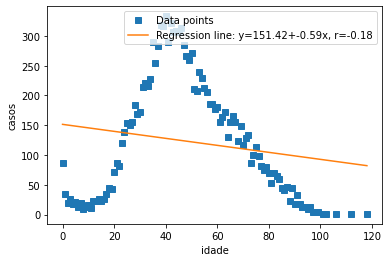

In [46]:
slope, intercept, pearsoncorrelation, p, stderr = scipy.stats.linregress(idade, casos)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={pearsoncorrelation:.2f}'
fig, ax = pyplot.subplots()
ax.plot(idade, casos, linewidth=0, marker='s', label='Data points')
ax.plot(idade, intercept + slope * idade, label=line)
ax.set_xlabel('idade')
ax.set_ylabel('casos')
ax.legend(facecolor='white')
pyplot.show()

### Referências:

2. Mukaka, M.M. «Statistics Corner: A guide to appropriate uso of Correlation coefficient in medical research». Malawai Medical Journal. PMC 3576830Acessível livremente. Consultado em 15 de agosto de 2020, as 12:55.